## <font color = 'darkblue'> **Sequência para chegar no melhor modelo**

1) Feito uma grande Análise Exploratória

2) Avaliando os dados geográficos com Geopandas

3) Desenvolvido notebook para o projeto de Machine Learning, com funções que podem facilitar testes de diferentes modelos

4) **Aprimorar o modelo de Machine Learning, seguindo as etapas abaixo:**
    - Linear Regression com preprocessamento só colunas categóricas, comparando com Dummy Regressor
    - Avaliado se a transformação de target melhorava modelo, e testado qual transformação de target era melhor (PowerTransform ou Quantile Transform)
    - Testado diferentes preprocessamento para colunas numéricas (só RobustScaler ou Standard Scaler + Power Transform) com a melhor transformação de target anterior
    - **Aplicado Polynomial Features para verifical qual grau do modelo ficava melhor, apenas com Robust Scaler para colunas numéricas e QuantileTransform para o target**
    - Substituído o Linear Regression pelo Elastic Net para verificar se alguma regularização melhorava o modelo
    - Substituído o ElasticNet pelo Ridge para verificar os resultado, definindo finalmente o melhor modelo

5) Salvar o melhor modelo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS

#from src.auxiliares import dataframe_coeficientes
#from src.graficos import (
#    plot_coeficientes,
#    plot_comparar_metricas_modelos,
#    plot_residuos_estimador,
)
#from src.models import (
#    organiza_resultados,
#    treinar_e_validar_modelo_regressao,
#    grid_search_cv_regressor,
#)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

#### **Fórmulas usadas para geração e avaliação dos modelos de machine learning deste projeto**

OBS: Expandir a célula abaixo caso queira consultar as fórmulas

In [ ]:
# Função para construir o pipeline do modelo d e regressão, caso exista ou não etapas de preprocessamento e transformação de target
def construir_pipeline_modelo_regressao(
    regressor, preprocessor=None, target_transformer=None
):
    if preprocessor is not None:
        pipeline = Pipeline([("preprocessor", preprocessor), ("reg", regressor)])
    else:
        pipeline = Pipeline([("reg", regressor)])

    if target_transformer is not None:
        model = TransformedTargetRegressor(
            regressor=pipeline, transformer=target_transformer
        )
    else:
        model = pipeline
    return model

# Função treinar o modelo de regressão e retornar os scores da validação cruzada
def treinar_e_validar_modelo_regressao(
    X,
    y,
    regressor,
    preprocessor=None,
    target_transformer=None,
    n_splits=5,
    random_state=RANDOM_STATE,
):

    model = construir_pipeline_modelo_regressao(
        regressor, preprocessor, target_transformer
    )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    scores = cross_validate(
        model,
        X,
        y,
        cv=kf,
        scoring=[
            "r2",
            "neg_mean_absolute_error",
            "neg_root_mean_squared_error",
        ],
    )

    return scores

# Após aplicar a função "treinar_e_validar_modelo_regressao" é aplicado essa função para obter um dataframe com as métricas de avaliação do modelo de regressão de acordo com a validação cruzada
def organiza_resultados(resultados):

    for chave, valor in resultados.items():
        resultados[chave]["time_seconds"] = (
            resultados[chave]["fit_time"] + resultados[chave]["score_time"]
        )

    df_resultados = (
        pd.DataFrame(resultados).T.reset_index().rename(columns={"index": "model"})
    )

    df_resultados_expandido = df_resultados.explode(
        df_resultados.columns[1:].to_list()
    ).reset_index(drop=True)

    try:
        df_resultados_expandido = df_resultados_expandido.apply(pd.to_numeric)
    except ValueError:
        pass

    return df_resultados_expandido

# Após aplicar a função "organiza_resultados(resultados)" é aplicado essa função para transformar os dados do dataframe em 4 gráficos
def plot_comparar_metricas_modelos(df_resultados):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

    comparar_metricas = [
        "time_seconds",
        "test_r2",
        "test_neg_mean_absolute_error",
        "test_neg_root_mean_squared_error",
    ]

    nomes_metricas = [
        "Tempo (s)",
        "R²",
        "MAE",
        "RMSE",
    ]

    for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):
        sns.boxplot(
            x="model",
            y=metrica,
            data=df_resultados,
            ax=ax,
            showmeans=True,
        )
        ax.set_title(nome)
        ax.set_ylabel(nome)
        ax.tick_params(axis="x", rotation=90)

    plt.tight_layout()

    plt.show()

# Função criada para utilizar a ferramenta grid_search para obter quais são os melhores parâmetros para o modelo de machine learning
def grid_search_cv_regressor(
    regressor,
    param_grid,
    preprocessor=None,
    target_transformer=None,
    n_splits=5,
    random_state=RANDOM_STATE,
    return_train_score=False,
):
    model = construir_pipeline_modelo_regressao(
        regressor, preprocessor, target_transformer
    )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        model,
        cv=kf,
        param_grid=param_grid,
        scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
        refit="neg_root_mean_squared_error",
        n_jobs=-1,
        return_train_score=return_train_score,
        verbose=1,
    )

    return grid_search

# Após ter definido o melhor modelo, é aplicado essa formula para comparar os dados previstos com os dados de teste
def plot_residuos_estimador(estimator, X, y, eng_formatter=False, fracao_amostra=0.25):

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    error_display_01 = PredictionErrorDisplay.from_estimator(
        estimator,
        X,
        y,
        kind="residual_vs_predicted",
        ax=axs[1],
        random_state=RANDOM_STATE,
        scatter_kwargs={"alpha": SCATTER_ALPHA},
        subsample=fracao_amostra,                       # Mostra o percentual dos dados que serão exibidos no gráfico
    )

    error_display_02 = PredictionErrorDisplay.from_estimator(
        estimator,
        X,
        y,
        kind="actual_vs_predicted",
        ax=axs[2],
        random_state=RANDOM_STATE,
        scatter_kwargs={"alpha": SCATTER_ALPHA},
        subsample=fracao_amostra,
    )

    residuos = error_display_01.y_true - error_display_01.y_pred

    sns.histplot(residuos, kde=True, ax=axs[0])

    if eng_formatter:                                              # É só pra melhorar a legenda dos eixos X e y, em vez de deixar 100000 e 20000 fica 100k e 200k
        for ax in axs:
            ax.yaxis.set_major_formatter(EngFormatter())
            ax.xaxis.set_major_formatter(EngFormatter())

    plt.tight_layout()

    plt.show()

#### **Separação das colunas do dataframe**

In [5]:
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_enconder = ['median_income_cat']

In [6]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_enconder)
colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

**OBS: Á FOI ANALISADO NO NOTEBOOK ANTERIOR QUE O ROBUST SCALER PRA TODAS COLUNAS NUMÉRICAS TEVE MELHOR DESEMPENHO DO QUE O STANDARD SCALER + POWER TRANSFORM**

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

#### **Definido o *"Preprocessamento Simples"* no notebook anterior para aplicar o *"Polynomial Features"*** 
- Foi o preprocessamento que trouxe melhores resultados pelo GridSearch no notebook anterior
- **OBS:** PolynomialFeatures() é uma etapa de *PREPROCESSAMENTO* dentro do Pipeline, pode até ser usada como um regressor, mas nesse exemplo está sendo usada junto com o modelo de LinearRegression </font

In [10]:
pipeline_robust = Pipeline(steps = [
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))             # Inicialmente será grau 1, mas vamos testar outros graus com o grid search
])

preprocessamento = ColumnTransformer(
    transformers = [
        ('one_hot_encoder', OneHotEncoder(drop='first'), coluna_one_hot_encoder),         # drop='first' --> Para reduzir o número de colunas no preprocessamento
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_enconder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler)      
    ],
)

In [11]:
preprocessamento

ColumnTransformer(transformers=[('one_hot_encoder', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat']),
                                ('robust_scaler_poly',
                                 Pipeline(steps=[('robust_scaler',
                                                  RobustScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False))]),
                                 Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])

#### **Testando qual grau de regressão polinomial é mais adequado pelo GridSearchCV*** 

In [15]:
param_grid = {
    'regressor__preprocessor__robust_scaler_poly__poly__degree': [1, 2, 3],
}

In [16]:
grid_search = grid_search_cv_regressor(
    regressor= LinearRegression(),
    preprocessor = preprocessamento,             
    target_transformer = QuantileTransformer(output_distribution='normal'),                # Já foi definido no notebook anterior que o QuantileTransformer trouxe melhores resultados
    param_grid = param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [17]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [18]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

In [19]:
grid_search.best_score_         # Veja que ficou do que os RMSE de -55011.704377 do Linear Regression + Power Transformer

-51130.01333902062

In [20]:
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat']),
                                                                                      ('robust_scaler_poly',
                                                                                       Pipeline(steps=[('robust_scaler',
                                                                                                        RobustScaler()),
                                                                                                       ('poly',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False))]),
                                                                                       Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                     ('reg',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [21]:
grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()

array(['one_hot_encoder__ocean_proximity_INLAND',
       'one_hot_encoder__ocean_proximity_NEAR BAY',
       'one_hot_encoder__ocean_proximity_NEAR OCEAN',
       'ordinal_encoder__median_income_cat',
       'robust_scaler_poly__bedrooms_per_room',
       'robust_scaler_poly__households',
       'robust_scaler_poly__housing_median_age',
       'robust_scaler_poly__latitude', 'robust_scaler_poly__longitude',
       'robust_scaler_poly__median_income',
       'robust_scaler_poly__population',
       'robust_scaler_poly__population_per_household',
       'robust_scaler_poly__rooms_per_household',
       'robust_scaler_poly__total_bedrooms',
       'robust_scaler_poly__total_rooms',
       'robust_scaler_poly__bedrooms_per_room^2',
       'robust_scaler_poly__bedrooms_per_room households',
       'robust_scaler_poly__bedrooms_per_room housing_median_age',
       'robust_scaler_poly__bedrooms_per_room latitude',
       'robust_scaler_poly__bedrooms_per_room longitude',
       'robust_scaler

In [22]:
grid_search.best_estimator_.regressor_['reg'].coef_

array([-4.16192525e-01, -2.07001861e-01, -5.69811497e-02, -1.91193863e-02,
        4.94430562e+02,  1.67582887e+05,  5.02965081e+03,  6.77066208e+03,
        7.73621402e+03,  1.42589640e+03, -1.39268261e+05,  5.23620919e+04,
        1.43118069e+04,  6.35600662e+03, -3.59193450e+04,  1.69756969e+04,
        2.20403876e+05, -2.71031987e+04, -6.16997440e+03, -5.69994082e+03,
       -6.50635669e+04, -2.28899456e+04,  3.66183100e+04,  1.58729915e+05,
       -4.93967026e+04, -1.61061951e+05, -2.03313838e+04,  5.97509284e+04,
       -2.46384840e+04,  1.33250387e+05, -4.14240745e+04, -5.68224890e+03,
        2.00372823e+04,  9.13471470e+04, -4.61273497e+04,  6.38895248e+04,
       -1.20938135e-02, -4.88663747e-01, -4.16277194e-01,  2.36487388e-01,
        1.00456221e+05, -3.89725804e+04,  5.93414691e+04,  7.01005276e+04,
       -2.27960539e+05, -1.21911230e+00, -1.86932374e+00, -4.54350813e-01,
        2.29067695e+05, -8.25215267e+04,  7.89974624e+04,  1.59574349e+04,
       -2.16919512e+05, -

In [ ]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_, 
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()
)

coefs

# Repare que possuem 367 coeficientes

,coeficiente
robust_scaler_poly__longitude total_rooms,-315595.263105
robust_scaler_poly__housing_median_age total_rooms,-227960.538814
robust_scaler_poly__latitude total_rooms,-216919.512059
robust_scaler_poly__rooms_per_household total_bedrooms,-213933.576829
robust_scaler_poly__latitude population_per_household total_rooms,-209329.439287
...,...
robust_scaler_poly__median_income total_bedrooms,168282.169672
robust_scaler_poly__longitude population,169861.201565
robust_scaler_poly__latitude population rooms_per_household,210689.039359
robust_scaler_poly__bedrooms_per_room households,220403.876274


**OBS**: Não será possível plotar o gráfico com todos os 367 coeficientes

In [32]:
coefs[coefs['coeficiente'] == 0]        # Não tem nenhum coeficiente nulo

,coeficiente


In [34]:
coefs[coefs['coeficiente'].between(-100_000, 100_000)]        # Repare que temos 343 coeficientes entre essa faixa

,coeficiente
robust_scaler_poly__households housing_median_age population_per_household,-94823.626780
robust_scaler_poly__population_per_household total_bedrooms,-87849.233949
robust_scaler_poly__latitude population_per_household,-82521.526709
robust_scaler_poly__housing_median_age population rooms_per_household,-66436.595743
robust_scaler_poly__households^2 population_per_household,-66198.133093
...,...
robust_scaler_poly__housing_median_age total_bedrooms,70100.527629
robust_scaler_poly__bedrooms_per_room rooms_per_household total_rooms,75122.729683
robust_scaler_poly__latitude rooms_per_household,78997.462418
robust_scaler_poly__rooms_per_household^2,80170.279850


In [36]:
# Podemos filtrar os coeficientes que estão fora dessa faixa

coefs[~coefs['coeficiente'].between(-100_000, 100_000)]

,coeficiente
robust_scaler_poly__longitude total_rooms,-315595.263105
robust_scaler_poly__housing_median_age total_rooms,-227960.538814
robust_scaler_poly__latitude total_rooms,-216919.512059
robust_scaler_poly__rooms_per_household total_bedrooms,-213933.576829
robust_scaler_poly__latitude population_per_household total_rooms,-209329.439287
robust_scaler_poly__bedrooms_per_room total_rooms,-161061.951264
robust_scaler_poly__households latitude rooms_per_household,-148890.075304
robust_scaler_poly__population,-139268.261208
robust_scaler_poly__median_income total_rooms,-123800.452209
robust_scaler_poly__longitude population_per_household total_rooms,-110446.325294


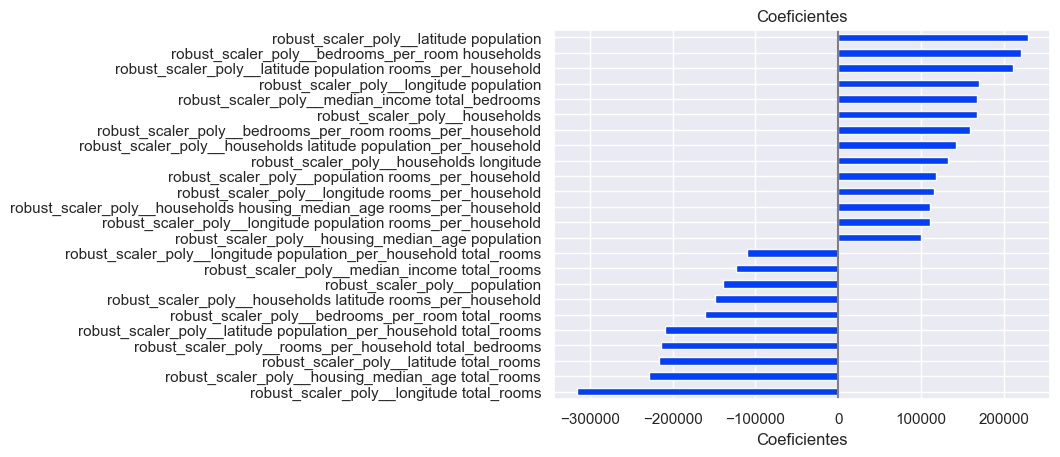

In [37]:
plot_coeficientes(coefs[~coefs['coeficiente'].between(-100_000, 100_000)])

# Plotando o gráfico dos coeficientes apenas maior ou menor que -100.000 e 100.000

#### **Comparando os modelos acima criados com o modelo com os melhores estimadores pelo GridSearchCV**

In [46]:
regressors = {
    "DummyRegressor": {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None
    },
    "LinearRegression": {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    "LinearRegression + Target Transformer": {    # Incluído esse regressor, pois aí a unica diferença pro GridSearch será as Polynomial Features (no proprocessamento tava definido grau 1)
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal')
    },
    "LinearRegression_GridSearchCV": {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer
    }, 
}

In [47]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor) for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.004737,0.006008,-0.000081,-77516.042766,-96239.705692,0.010745
1,DummyRegressor,0.004124,0.004821,-0.000146,-75787.787194,-95217.629397,0.008945
2,DummyRegressor,0.00323,0.003752,-0.001737,-76753.598961,-96253.253947,0.006982
3,DummyRegressor,0.003219,0.003762,-0.000101,-76837.804811,-95983.885799,0.006981
4,DummyRegressor,0.003205,0.005173,-0.000114,-76617.245449,-96182.764729,0.008378
5,LinearRegression,0.111942,0.012104,0.682162,-39855.690996,-54254.958188,0.124046
6,LinearRegression,0.102725,0.015964,0.66999,-40272.565467,-54695.230283,0.118689
7,LinearRegression,0.113694,0.01155,0.649247,-42178.05929,-56955.988706,0.125244
8,LinearRegression,0.101779,0.010108,0.669873,-40806.492497,-55146.318803,0.111887
9,LinearRegression,0.147615,0.008966,0.669023,-40788.496497,-55331.35106,0.156581


In [48]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003703,0.004703,-0.000436,-76702.495836,-95975.447913,0.008406
LinearRegression,0.115551,0.011738,0.668059,-40780.26095,-55276.769408,0.127289
LinearRegression + Target Transformer,0.138972,0.011572,0.677969,-38674.721229,-54441.466092,0.150544
LinearRegression_GridSearchCV,6.875962,0.03869,0.715745,-35576.01495,-51145.392086,6.914651


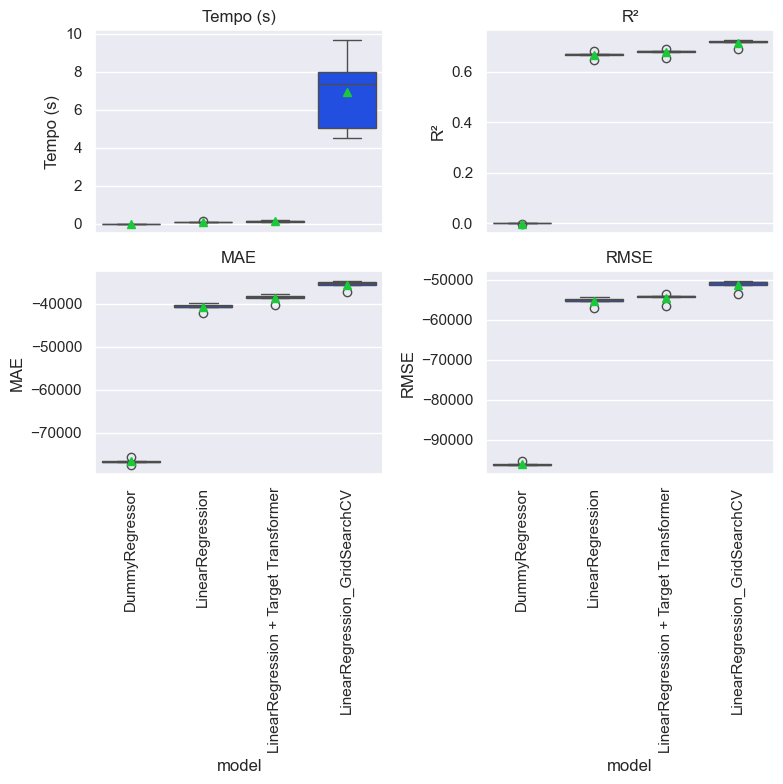

In [49]:
plot_comparar_metricas_modelos(df_resultados)         # Veja que os resultados obtido com o QuantileTrasnformer foram melhores, com menor tempo de execução do que com PowerTransformer